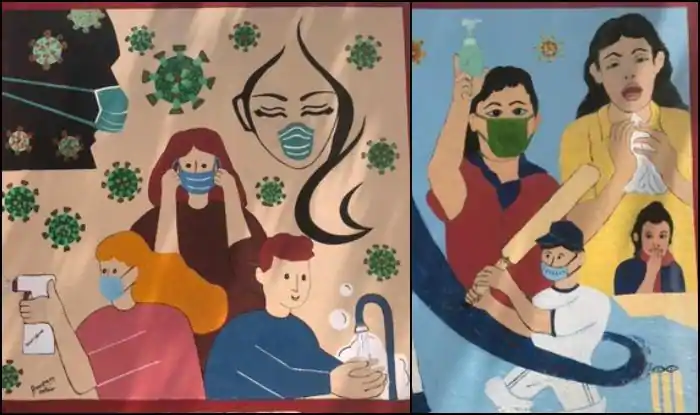
 
 

**Aim:**
To understand the impact of various social interventions in restraining the spread of Covid-19. Here I have tried to visualize following things:


1. How different factors are correlated to each other
2. Country-wise Covid-19 stats
3. Absolute change in the count of various Covid-19 stats in India
4. Percent-change in various Covid-19 stats in India

**Approach:**

1. Utilized two datasets. Merged the data based on a couple of columns.
2. Cleaned the data (Remove null and redundant values, group the values, filter the values, etc) 
3. Visualize the data using Plotly.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
from sklearn.impute import SimpleImputer

In [ ]:
import plotly.express as px
import plotly.offline as offline
from plotly.offline import init_notebook_mode,iplot
import plotly.graph_objects as go
import cufflinks as cf
init_notebook_mode(connected=True)

import pandas as pd
import numpy as np

# **First Dataset(D1): HDE acaps-covid-19-government-measures**

This dataset is useful to identify different types of 'Social Interventions' and their implementation dates.

In [ ]:
gov_measures_data = pd.read_csv('../input/uncover/UNCOVER_v4/UNCOVER/HDE/HDE/acaps-covid-19-government-measures-dataset.csv')

In [ ]:
gov_measures_data.shape

In [ ]:
gov_measures_data.describe()

In [ ]:
gov_measures_data.info()

# **Second dataset(D2): our_world_in_data -- coronavirus-disease-covid-19-statistics-and-research**

This dataset provides various Covid-19 stats, country-wise (e.g.: Total cases, New cases, Total deaths, New deaths, etc)

In [ ]:
covid19_stats_data = pd.read_csv('../input/uncover/UNCOVER_v4/UNCOVER/our_world_in_data/coronavirus-disease-covid-19-statistics-and-research.csv')

In [ ]:
covid19_stats_data.shape

In [ ]:
covid19_stats_data.info()

# Merging D2 with D1 using 'Outer' merge

In [ ]:
covid19_stats_with_gov_measures_data = pd.merge(covid19_stats_data, gov_measures_data, how='outer', left_on=['iso_code', 'date'], right_on=['iso', 'date_implemented'])

In [ ]:
covid19_stats_with_gov_measures_data.shape

Drop unnecessary columns

In [ ]:
covid19_stats_with_gov_measures_data = covid19_stats_with_gov_measures_data.drop(['id','pcode','comments','source', 'source_type', 'link', 'alternative_source'], axis=1)

Sync the data of similar columns

In [ ]:
covid19_stats_with_gov_measures_data.country.fillna(covid19_stats_with_gov_measures_data.location, inplace=True)
covid19_stats_with_gov_measures_data.iso_code.fillna(covid19_stats_with_gov_measures_data.iso, inplace=True)
covid19_stats_with_gov_measures_data.date_implemented.fillna(covid19_stats_with_gov_measures_data.date, inplace=True)

Drop the redundant columns

In [ ]:
covid19_stats_with_gov_measures_data = covid19_stats_with_gov_measures_data.drop(['location', 'iso'], axis=1)

Check for any NaN values in Country column

In [ ]:
covid19_stats_with_gov_measures_data[covid19_stats_with_gov_measures_data['country'].isna()]

Create new dataframe have no NaN values in 'country'column

In [ ]:
covid19_stats_with_gov_measures_data = covid19_stats_with_gov_measures_data.dropna(subset=['country', 'date'])

Remove case-sensitive Country name duplicates ('Moldova Republic Of' & 'Moldova Republic of') and country that do not have useful data.

In [ ]:
covid19_stats_with_gov_measures_data = covid19_stats_with_gov_measures_data[(covid19_stats_with_gov_measures_data['country'] != 'Moldova Republic of') & (covid19_stats_with_gov_measures_data['country'] != 'Czech republic') & (covid19_stats_with_gov_measures_data['country'] != 'Afghanistan')]

Unique Country list

In [ ]:
countries = covid19_stats_with_gov_measures_data.country.unique()

List of numeric and non-numeric columns

In [ ]:
numeric_cols = list(covid19_stats_with_gov_measures_data.select_dtypes(include=['number']).columns)
non_numeric_cols = list(covid19_stats_with_gov_measures_data.select_dtypes(exclude=['number']).columns)

In [ ]:
for col in numeric_cols:
    for country in countries:
        mask = (covid19_stats_with_gov_measures_data['country']==country)
        sum_notna = covid19_stats_with_gov_measures_data.loc[mask, col].notna().sum()
        col_mean = 0
        if sum_notna > 0:
            col_mean = covid19_stats_with_gov_measures_data[mask][col].mean(skipna = True)
            
        covid19_stats_with_gov_measures_data[col].fillna(col_mean, inplace=True)

In [ ]:
for col in non_numeric_cols:
    for country in countries:
        mask = (covid19_stats_with_gov_measures_data['country']==country)
        mask2 = (covid19_stats_with_gov_measures_data['country']==country) & covid19_stats_with_gov_measures_data[col].notna()
        sum_notna = covid19_stats_with_gov_measures_data.loc[mask, col].notna().sum()
        if(sum_notna > 0):
            imputer = SimpleImputer(strategy='most_frequent')
            covid19_stats_with_gov_measures_data[mask2][col] = imputer.fit_transform(covid19_stats_with_gov_measures_data[mask2])

Adding new column 'percent_change_per_day'

In [ ]:
for country in countries:
    mask = (covid19_stats_with_gov_measures_data['country']==country)
    

In [ ]:
covid19_stats_with_gov_measures_data = covid19_stats_with_gov_measures_data[covid19_stats_with_gov_measures_data['measure'].notna()]

In [ ]:
covid19_stats_with_gov_measures_data['date_implemented'] = pd.to_datetime(covid19_stats_with_gov_measures_data['date_implemented'])
covid19_stats_with_gov_measures_data['entry_date'] = pd.to_datetime(covid19_stats_with_gov_measures_data['entry_date'])
covid19_stats_with_gov_measures_data['date'] = pd.to_datetime(covid19_stats_with_gov_measures_data['date'])

In [ ]:
covid19_stats_with_gov_measures_data[non_numeric_cols]

In [ ]:
covid19_stats_measures_df1 = covid19_stats_with_gov_measures_data[covid19_stats_with_gov_measures_data.columns[~covid19_stats_with_gov_measures_data.columns.isin(['tests_units', 'admin_level_name', 'non_compliance'])]]

In [ ]:
non_numeric_cols_df1 = list(covid19_stats_measures_df1.select_dtypes(include=['object']).columns)

In [ ]:
covid19_stats_measures_df1[non_numeric_cols_df1]

In [ ]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(20, 12))
corr = covid19_stats_measures_df1.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('DS1+DS2 Covid-19 statistics Correlation Heatmap', fontsize=14)

Updated list of unique countries

In [ ]:
countries = covid19_stats_measures_df1.country.unique()

Interactive plot to visualize data country-wise.

In [ ]:
fig2 = go.Figure()

col_to_plot=["total_cases", "total_deaths", "new_cases", "new_deaths"]

updatemenu= []
buttons = []

data = []

for n, country in enumerate(countries):
    visible = [False] * len(countries)
    visible[n] = True
    temp_dict = dict(label = str(country),
                    method = 'update',
                    args = [{'visible': visible},
                           {'title': 'Country %s' % country}])
    updatemenu.append(temp_dict)
    

for n, col in enumerate(col_to_plot):
    for country in countries:
        mask = (covid19_stats_measures_df1.country.values == country)
        trace = (dict(
            visible = False,
            name = col,
            x = covid19_stats_measures_df1.loc[mask, 'date'],
            y = covid19_stats_measures_df1.loc[mask, col],
            mode='lines+markers'
        ))
        
        data.append(trace)
    

layout = dict(updatemenus = list([dict(buttons = updatemenu)]), title = "COVID-19 stats")

fig2 = dict(data = data, layout = layout)
offline.iplot(fig2, filename = 'update_dropdown')

Analysis of Covid-19 data for India

In [ ]:
covid19_stats_measures_df1_india = covid19_stats_measures_df1[covid19_stats_measures_df1['country']=='India']

In [ ]:
covid19_stats_measures_df1_india['percent_change_total_cases'] = covid19_stats_measures_df1_india['total_cases'].pct_change();
covid19_stats_measures_df1_india['percent_change_total_deaths'] = covid19_stats_measures_df1_india['total_deaths'].pct_change();
covid19_stats_measures_df1_india['percent_change_new_cases'] = covid19_stats_measures_df1_india['new_cases'].pct_change();
covid19_stats_measures_df1_india['percent_change_new_deaths'] = covid19_stats_measures_df1_india['new_deaths'].pct_change();

In [ ]:
covid19_stats_measures_df1_india.replace([np.inf, -np.inf], np.nan,inplace=True)

In [ ]:
covid19_stats_measures_df1_india = covid19_stats_measures_df1_india.fillna(0)

In [ ]:
covid19_stats_measures_df1_india[['date', 'total_cases', 'percent_change_total_cases', 'total_deaths', 'percent_change_total_deaths', 'new_cases', 'percent_change_new_cases', 'new_deaths', 'percent_change_new_deaths']]

The black marker line indicates the date on which Full Lockdown was implemented.

In [ ]:
full_lockdown_date = covid19_stats_measures_df1_india[covid19_stats_measures_df1_india['measure'] == "Full lockdown"].date_implemented
full_lockdown_date= np.datetime_as_string(full_lockdown_date, unit='D')


fig_new_case_count = px.line(covid19_stats_measures_df1_india, x="date", y=["new_cases"], log_y=False, title="Effect of Full Lockdown on Count of New Covid-19 cases in India")
fig_new_case_count.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= full_lockdown_date[0], x1= full_lockdown_date[0]
    )
])
fig_new_case_count.show()

fig_new_case_percent = px.line(covid19_stats_measures_df1_india, x="date", y=["percent_change_new_cases"], log_y=False, title="Effect of Full Lockdown on Percent change in New Covid-19 cases in India")
fig_new_case_percent.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= full_lockdown_date[0], x1= full_lockdown_date[0]
    )
])
fig_new_case_percent.show()

**Conclusion:**
As we can from above two plots, though the absolute count of number of 'New cases' increased, the percent increase in 'New cases' gradually flattend after the implementation of Full Lockdown. 